This notebook will walk you through the implementation of the **trajectory planning** problem for a unmanned aerial vehicle (UAV). For simplicity, we only focus on the case where the motion is restricted in only two dimensions, say $y$- and $z$-directions.

The UAV is supposed to start off from some initial position, and then pass through a set of waypoints in turn. We will be looking for a trajectory with the **minimum jerk**.

It can be shown by the use of *variational principle* that the minimum jerk route is a piecewise polynomial function satisfying a set of boundary conditions. The mathematics behind the algorithm is a bit too involved, so I am not going into this in the notebook, but you can have a look at my Zhihu article here: [[https://zhuanlan.zhihu.com/p/419830521]](https://zhuanlan.zhihu.com/p/419830521)

The details of the implementation are given in the code comments.

In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def yz_coeffs(wp):
    # generates coefficients for the polynomials that give desired y- and z-values at time t
    # output format: [[y, y_dot, y_dot_dot], [z, z_dot, z_dot_dot]]
    
    # required inputs:
    # t = time series, 
    # wp = waypoints: a list of waypoints in terms of 3D vectors
    # waypoint given as [t, y, z]
    # the quadrotor need find itself at coordinates (y, z) at time t
    
    n = len(wp) - 1
    
    # initialise a 6n * 6n coefficient matrix and a 6n-dimensional vector
    # we are looking for a trajectory with the minimum snap
    # the desired trajectory consists of sections that are described by polynomial functions of t
    # it can be shown that the order of the polynomial is 5
    # so for each piecewise function, there are 6 parameters to be determined
    # we are setting up a matrix equation to compute a total number of 6*n parameters
    
    coeffs = []
    ysol = []
    zsol = []
    
    # conditions that must be satisfied if r(t) match at each waypoint
    for i in range(n):
        # initial value for each piecewise polynomial
        result = [0] * 6 * i
        temp = [wp[i][0]**5, wp[i][0]**4, wp[i][0]**3, wp[i][0]**2, wp[i][0], 1]
        result += temp
        result += [0] * 6 * (n-i-1)
        coeffs.append(result)
        ysol.append(wp[i][1])
        zsol.append(wp[i][2])
    
        # final value for each piecewise polynomial
        result = [0] * 6 * i
        temp = [wp[i+1][0]**5, wp[i+1][0]**4, wp[i+1][0]**3, wp[i+1][0]**2, wp[i+1][0], 1]
        result += temp
        result += [0] * 6 * (n-i-1)
        coeffs.append(result)
        ysol.append(wp[i+1][1])
        zsol.append(wp[i+1][2])
        
    # conditions that must be satisfied if initial speed is zero
    result = []
    temp = [5 * wp[0][0]**4, 4 * wp[0][0]**3, 3 * wp[0][0]**2, 2 * wp[0][0], 1, 0]
    result += temp
    result += [0] * 6 * (n-1)
    coeffs.append(result)
    ysol.append(0)
    zsol.append(0)
    
    # conditions that must be satisfied if final speed is zero
    result = [0] * 6 * (n-1)
    temp = [5 * wp[n][0]**4, 4 * wp[n][0]**3, 3 * wp[n][0]**2, 2 * wp[n][0], 1, 0]
    result += temp
    coeffs.append(result)
    ysol.append(0)
    zsol.append(0)
    
    # conditions that must be satisfied if initial acceleration is zero
    result = []
    temp = [20 * wp[0][0]**3, 12 * wp[0][0]**2, 6 * wp[0][0], 2, 0, 0]
    result += temp
    result += [0] * 6 * (n-1)
    coeffs.append(result)
    ysol.append(0)
    zsol.append(0)

    # conditions that must be satisfied if final acceleration is zero
    result = [0] * 6 * (n-1)
    temp = [20 * wp[n][0]**3, 12 * wp[n][0]**2, 6 * wp[n][0], 2, 0, 0]
    result += temp
    coeffs.append(result)
    ysol.append(0)
    zsol.append(0)
    
    # conditions that must be satisfied if velocity is continuous at each waypoint
    for i in range(n-1):
        result = [0] * 6 * i
        temp1 = [5 * wp[i+1][0]**4, 4 * wp[i+1][0]**3, 3 * wp[i+1][0]**2, 2 * wp[i+1][0], 1, 0]
        temp2 = [-5 * wp[i+1][0]**4, -4 * wp[i+1][0]**3, -3 * wp[i+1][0]**2, -2 * wp[i+1][0], -1, 0]
        result += temp1 + temp2
        result += [0] * 6 * (n-i-2)
        coeffs.append(result)
        ysol.append(0)
        zsol.append(0)
        
    # conditions that must be satisfied if acceleration is continuous at each waypoint
    for i in range(n-1):
        result = [0] * 6 * i
        temp1 = [20 * wp[i+1][0]**3, 12 * wp[i+1][0]**2, 6 * wp[i+1][0], 2, 0, 0]
        temp2 = [-20 * wp[i+1][0]**3, -12 * wp[i+1][0]**2, -6 * wp[i+1][0], -2, 0, 0]
        result += temp1 + temp2
        result += [0] * 6 * (n-i-2)
        coeffs.append(result)
        ysol.append(0)
        zsol.append(0)
        
    # conditions that must be satisfied if third and fourth derivative of r(t) are also continuous
    for i in range(n-1):
        result = [0] * 6 * i
        temp1 = [60 * wp[i+1][0]**2, 24 * wp[i+1][0], 6, 0, 0, 0]
        temp2 = [-60 * wp[i+1][0]**2, -24 * wp[i+1][0], -6, 0, 0, 0]
        result += temp1 + temp2
        result += [0] * 6 * (n-i-2)
        coeffs.append(result)
        ysol.append(0)
        zsol.append(0)
    
    for i in range(n-1):
        result = [0] * 6 * i
        temp1 = [120 * wp[i+1][0], 24, 0, 0, 0, 0]
        temp2 = [-120 * wp[i+1][0], -24, 0, 0, 0, 0]
        result += temp1 + temp2
        result += [0] * 6 * (n-i-2)
        coeffs.append(result)
        ysol.append(0)
        zsol.append(0)
    
    # we arrange the coefficients of the polynomials into a column vector c
    # they must satisfy the matrix equation of the form M c = Y or Z
    # by taking the inverse of M, the coefficients can be obtained
    
    M = np.array(coeffs)
    Y = np.array(ysol)
    Z = np.array(zsol)
    
    c_y = np.matmul( np.linalg.inv(M), np.transpose(Y))
    c_z = np.matmul( np.linalg.inv(M), np.transpose(Z))
    
    return c_y, c_z   

In [3]:
def traj_des(n_iter, wp):
    # generate a collections of y-, z-values for the desired trajectory
    # plot the trajectory and see how it fits all the waypoints
    # required input: number of grids for time series + list of waypoints
    
    t_max = 0
    for p in wp:
        if p[0] > t_max:
            t_max = p[0]
    t_step = t_max/(n_iter-1)

    # setting up the arrays to store desired trajectory
    y_des, y_dot_des, y_dotdot_des = np.zeros(n_iter), np.zeros(n_iter), np.zeros(n_iter)
    z_des, z_dot_des, z_dotdot_des = np.zeros(n_iter), np.zeros(n_iter), np.zeros(n_iter)
    
    # compute the coefficients for the polynomial
    c_y, c_z = yz_coeffs(wp)

    # compute coordinates of the desired trajectory
    for k in range(n_iter):
        t = k * t_step
        for i in range(len(wp)-1):
            if t >= wp[i][0]:
                y_des[k] = c_y[6*i] * t**5 + c_y[6*i + 1] * t**4 + c_y[6*i + 2] * t**3 + c_y[6*i + 3] * t**2 + c_y[6*i + 4] * t + c_y[6*i + 5]
                y_dot_des[k] = 5 * c_y[6*i] * t**4 + 4 * c_y[6*i + 1] * t**3 + 3 * c_y[6*i + 2] * t**2 + 2 * c_y[6*i + 3] * t + c_y[6*i + 4]
                y_dotdot_des[k] = 20 * c_y[6*i] * t**3 + 12 * c_y[6*i + 1] * t**2 + 6 * c_y[6*i + 2] * t + 2 * c_y[6*i + 3]
                z_des[k] = c_z[6*i] * t**5 + c_z[6*i + 1] * t**4 + c_z[6*i + 2] * t**3 + c_z[6*i + 3] * t**2 + c_z[6*i + 4] * t + c_z[6*i + 5]
                z_dot_des[k] = 5 * c_z[6*i] * t**4 + 4 * c_z[6*i + 1] * t**3 + 3 * c_z[6*i + 2] * t**2 + 2 * c_z[6*i + 3] * t + c_z[6*i + 4]
                z_dotdot_des[k] = 20 * c_z[6*i] * t**3 + 12 * c_z[6*i + 1] * t**2 + 6 * c_z[6*i + 2] * t + 2 * c_z[6*i + 3]
    
    return [[y_des, y_dot_des, y_dotdot_des], [z_des, z_dot_des, z_dotdot_des]]

In [4]:
def plot_traj(n_iter, wp):
    # plotting the minimum jerk trajectory: a graph of z(t) against y(t)
    # required input: number of grids for time series + list of waypoints
    
    # extract coordinates of waypoints
    Y_wp = []
    Z_wp = []
    for i in range(len(wp)):
        Y_wp.append(wp[i][1])
        Z_wp.append(wp[i][2])
        
    result = traj_des(n_iter, wp)
    y_des, z_des = result[0][0], result[1][0]
    
    plt.plot(y_des, z_des, color='red')
    plt.scatter(Y_wp, Z_wp)
    plt.xlabel('Horizontal Distance')
    plt.ylabel('Height')
    plt.show()

In [5]:
# define waypoints
wp1 = [[0, 0, 0], [1, 1, 2], [2, 3, 3], [3, 4.5, 5], [5, 8, 4], [7, 10, 2], [9, 12, 5]]

In [6]:
# define constant parameters
t_step = 0.01
n_iter = 900
t_range = np.arange(0.0, n_iter*t_step, t_step)

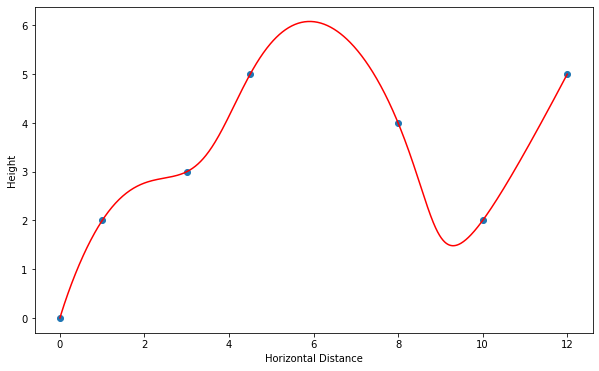

In [12]:
plot_traj(n_iter, wp1)

In [8]:
# 2D PD controller
# required parameters: Kp and Kd parameters for y, z and phi
# 'func' is a Python function that describes the desired trajectory for the UAV to follow
def controller(K, n_iter, func, wp):
    Kp_y, Kd_y, Kp_z, Kd_z, Kp_phi, Kd_phi = K
    
    t_max = 0
    for p in wp:
        if p[0] > t_max:
            t_max = p[0]
    t_step = t_max/(n_iter-1)
    
    # setting up the arrays to store desired trajectory and actual trajectory
    y, y_dot, y_dotdot = np.zeros(n_iter), np.zeros(n_iter), np.zeros(n_iter)
    z, z_dot, z_dotdot = np.zeros(n_iter), np.zeros(n_iter), np.zeros(n_iter)
    phi, phi_dot, phi_dotdot = np.zeros(n_iter), np.zeros(n_iter), np.zeros(n_iter)
    phi_des = np.zeros(n_iter)
    
    # initialising the arrays to store the required thrust and torque
    F = np.zeros(n_iter)
    tau = np.zeros(n_iter)

    # setting up the initial values for actual trajectory
    y[0], y_dot[0], y_dotdot[0] = y0, y_dot0, y_dotdot0
    z[0], z_dot[0], z_dotdot[0] = z0, z_dot0, z_dotdot0
    F[0] = mass * g

    # feed in coordinates, velocities for desired trajectory
    y_des, y_dot_des, y_dotdot_des = traj_des(n_iter, wp)[0]
    z_des, z_dot_des, z_dotdot_des = traj_des(n_iter, wp)[1]

    # error = desired trajectory - actual trajectory
    # the goal is to let the error decrease to zero quickly
    # this allows us to determine the acceleration at any time instant
    for i in range(1, n_iter):    
        # equations of motion for quadrotor in y, z and phi
        y_dotdot[i] = -F[i-1]/mass * np.sin(phi[i-1])
        z_dotdot[i] = F[i-1]/mass * np.cos(phi[i-1]) - g
        phi_dotdot[i] = tau[i-1] / Ixx
    
        # estimate actual trajectory using difference method
        y[i] = y[i-1] + y_dot[i-1] * t_step
        y_dot[i] = y_dot[i-1] + y_dotdot[i-1] * t_step
        z[i] = z[i-1] + z_dot[i-1] * t_step
        z_dot[i] = z_dot[i-1] + z_dotdot[i-1] * t_step
        phi[i] = phi[i-1] + phi_dot[i-1] * t_step
        phi_dot[i] = phi_dot[i-1] + phi_dotdot[i-1] * t_step
        
        # compute the required output from PD controller
        ydotdot_c = y_dotdot_des[i] + Kd_y * (y_dot_des[i] - y_dot[i]) + Kp_y * (y_des[i] - y[i])
        zdotdot_c = z_dotdot_des[i] + Kd_z * (z_dot_des[i] - z_dot[i]) + Kp_z * (z_des[i] - z[i])
        F[i] = mass * np.sqrt(ydotdot_c ** 2 + (g + zdotdot_c) ** 2)
        phi_des[i] = np.arcsin(- mass * ydotdot_c / F[i])
        phi_des_dot = (phi_des[i] - phi_des[i-1])/t_step
        tau[i] = Ixx * (Kd_phi * (phi_des_dot - phi_dot[i]) + Kp_phi * (phi_des[i] - phi[i]))  
    
    Y_wp = []
    Z_wp = []
    for i in range(len(wp)):
        Y_wp.append(wp[i][1])
        Z_wp.append(wp[i][2])

    plt.plot(y_des, z_des, color='gray', label='Desired Trajectory')
    plt.plot(y, z, color='blue', label='Actual Trajectory')
    plt.scatter(Y_wp, Z_wp, marker='x', color='red', label='Waypoints')
    plt.legend()
    plt.ylabel('Vertical Height (metres)')
    plt.xlabel('Horizontal Distance (metres)')
    plt.rcParams["figure.figsize"] = (10, 6)
    plt.show()

In [9]:
# now consider a quadrotor that is required to move through the waypoints
# we have already found an optimal trajectory for the quadrotor
# we can also use PD controller to manipulate its motion so that it travels along the desired path

# define physical constants of the quadrotor
mass = 0.2
Ixx = 0.008
g = 9.81

# define initial state: resting at the origin
y0, y_dot0, y_dotdot0 = 0, 0, 0
z0, z_dot0, z_dotdot0 = 0, 0, 0

# define PD control parameters
Kp_y = 15
Kd_y = 3
Kp_z = 15
Kd_z = 3
Kp_phi = 200
Kd_phi = 20
K = Kp_y, Kd_y, Kp_z, Kd_z, Kp_phi, Kd_phi

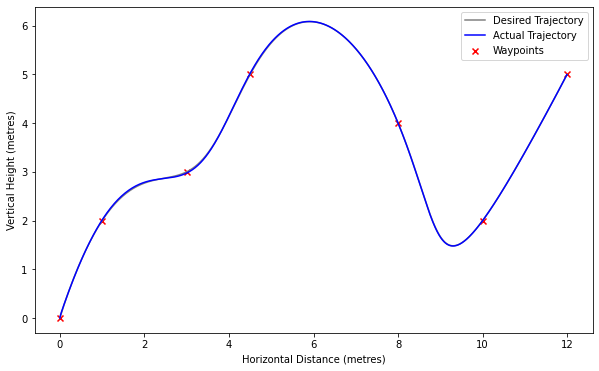

In [13]:
controller(K, n_iter, traj_des, wp1)

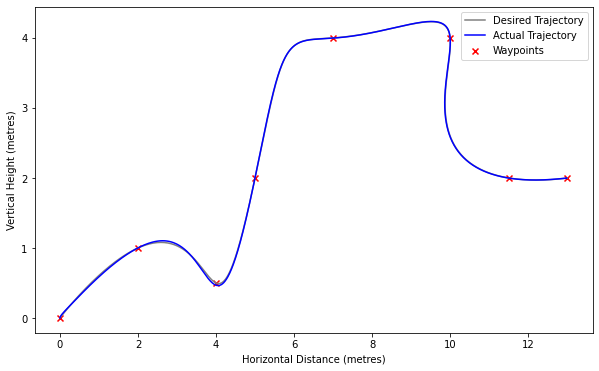

In [11]:
# define another set of waypoints for testing
wp2 = [[0, 0, 0], [1, 2, 1], [2, 4, 0.5], [3, 5, 2], [5, 7, 4], [7, 10, 4], [9, 11.5, 2], [10, 13, 2]]
controller(K, n_iter, traj_des, wp2)